### Rips and alpha complexes from matrix of pairwise distances

In [1]:

import numpy as np
import pickle as pck
import pandas as pd
import matplotlib.pyplot as plt
import gudhi as gd
from gudhi.representations.preprocessing import BirthPersistenceTransform
from gudhi.representations import PersistenceImage
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
#from xgboost import XGBClassifier
import os

from multiplier import *

In [2]:
# Define the paths to the files
path_file = "./ECG5000/"
train_file = "ECG5000_TRAIN.tsv"
test_file = "ECG5000_TEST.tsv"
labels_file = "labels.txt"

# Load the training set, test set, and labels file
train_data = pd.read_csv(path_file + train_file, sep="\t", header=None)
test_data = pd.read_csv(path_file + test_file, sep="\t", header=None)

corr_list = []

train_corr = train_data.corr()
test_corr = test_data.corr()
corr_list.append(train_corr)
corr_list.append(test_corr)

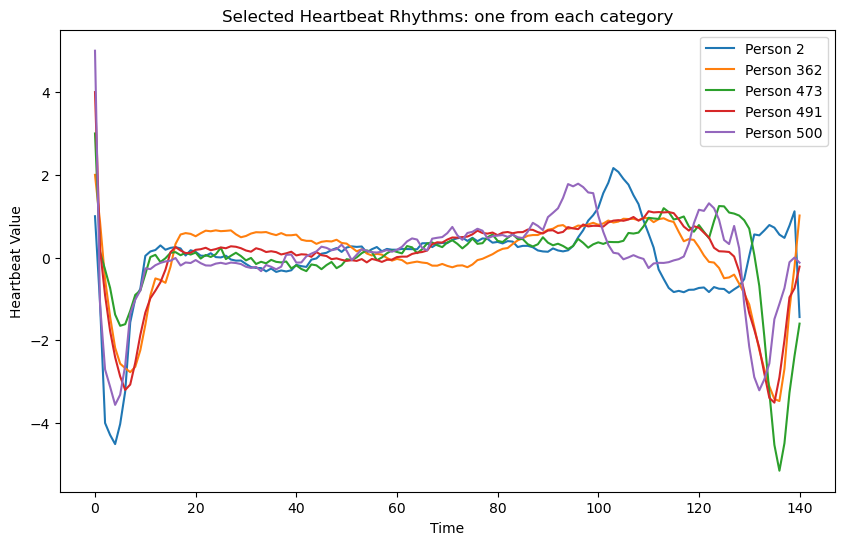

In [3]:
# plot the first few heart rhythms 

selected_rows = [1, 361, 472, 490, 499]  # Adjust the list to include the indices you want

plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

for index in selected_rows:
    plt.plot(train_data.iloc[index].values, label=f'Person {index+1}')

# Customize the plot
plt.title('Selected Heartbeat Rhythms: one from each category')
plt.xlabel('Time')
plt.legend(loc='best')
plt.ylabel('Heartbeat Value') 
plt.show()

In [4]:
# Go through each person and make a persistence diagram for each one and add it to a list of all heartbeats 

barcodes_list = []

for index, row in train_data.iterrows():
    data = train_data.iloc[index].values.reshape(-1, 1)
    
    distance_matrix = pairwise_distances(data)
    
    skeleton = gd.RipsComplex(
        distance_matrix=distance_matrix, max_edge_length= 0.8)
    
    Rips_simplex_tree = skeleton.create_simplex_tree(max_dimension=2)

    rips_filtration = Rips_simplex_tree.get_filtration()
    rips_list = list(rips_filtration)


    BarCodes_Rips = Rips_simplex_tree.persistence()


    BarCodes_Rips_0 = Rips_simplex_tree.persistence_intervals_in_dimension(0)
    #BarCodes_Rips_1 = Rips_simplex_tree.persistence_intervals_in_dimension(1)
    
    # only adding in dimension 0 because cycles not present in this data
    barcodes_list.append(BarCodes_Rips_0)

In [5]:
# now we will repeat the above but only for the second half of the data

barcodes_list_mod = []

for index, row in train_data.iterrows():
    
    data = train_data.iloc[index, -60:].values.reshape(-1, 1)
    
    distance_matrix = pairwise_distances(data)
    
    skeleton = gd.RipsComplex(
        distance_matrix=distance_matrix, max_edge_length= 0.8)
    
    Rips_simplex_tree = skeleton.create_simplex_tree(max_dimension=2)

    rips_filtration = Rips_simplex_tree.get_filtration()
    rips_list = list(rips_filtration)

    
    BarCodes_Rips = Rips_simplex_tree.persistence()
    
    BarCodes_Rips_0 = Rips_simplex_tree.persistence_intervals_in_dimension(0)
    
    barcodes_list_mod.append(BarCodes_Rips_0)

In [6]:
# now create persistence images for each one 

persistence_img_list = []
persistence_img_list_mod = []

for index, row in train_data.iterrows():
    

    persistence_image = PersistenceImage(bandwidth=0.2, im_range=[0, 1, 0, 1], resolution=[20, 20])
    
    BarCodes_Rips_0 = barcodes_list[index]
    persistence_image_H0 = persistence_image.fit_transform([BarCodes_Rips_0])[0]
    
    persistence_image_mod = PersistenceImage(bandwidth=0.2, im_range=[0, 1, 0, 1] ,resolution=[20, 20])
    BarCodes_Rips_0_mod = barcodes_list_mod[index]
    persistence_image_H0_mod = persistence_image.fit_transform([BarCodes_Rips_0_mod])[0]
    
    persistence_img_list.append(persistence_image_H0)
    persistence_img_list_mod.append(persistence_image_H0_mod)

/opt/anaconda3/lib/python3.11/site-packages/gudhi/persistence_graphical_tools.py:105: UserWarning: This function is not available.
ModuleNotFoundError: No module named 'matplotlib'.
  warnings.warn(f"This function is not available.\nModuleNotFoundError: No module named '{import_error.name}'.")


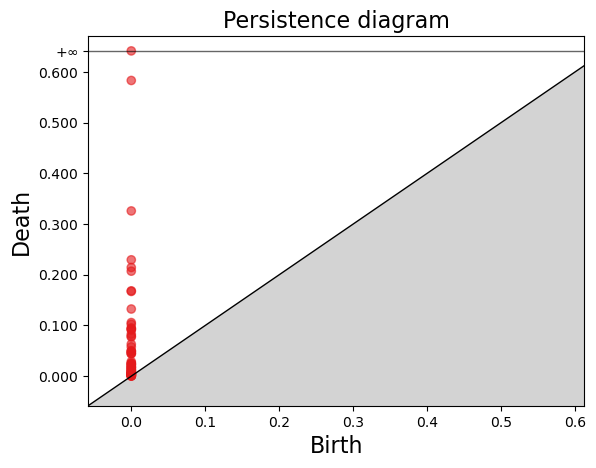

<Figure size 1000x600 with 0 Axes>

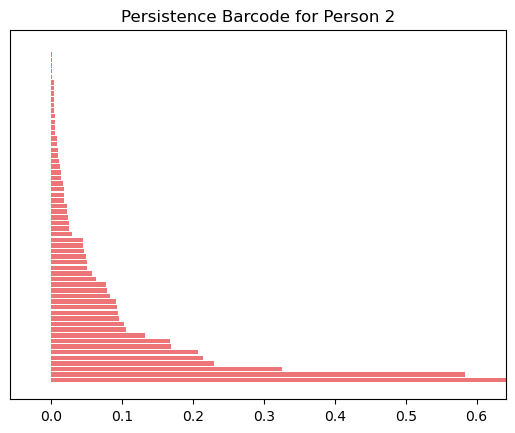

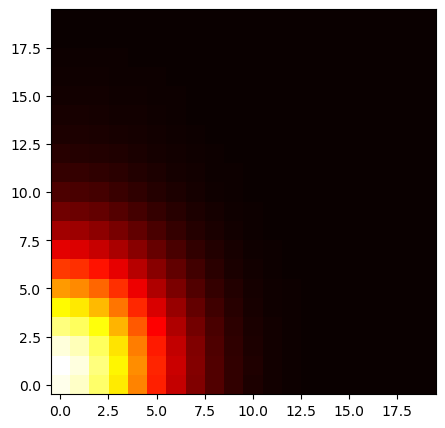

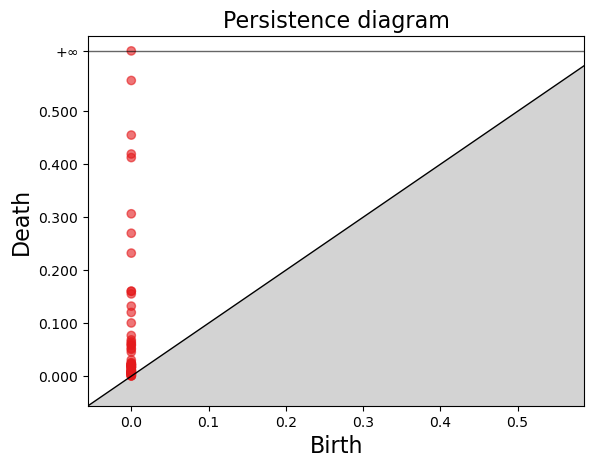

<Figure size 1000x600 with 0 Axes>

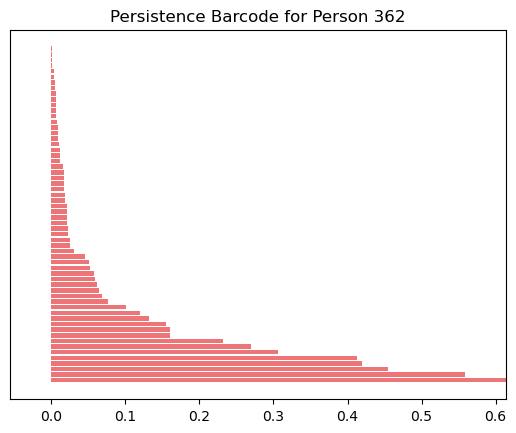

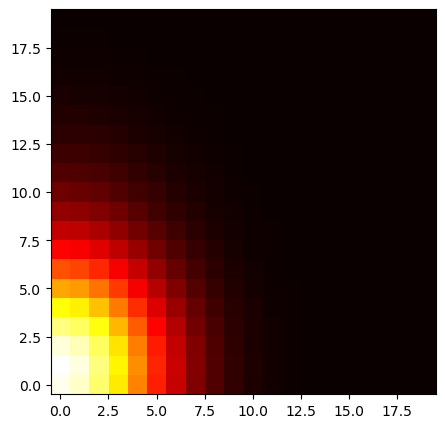

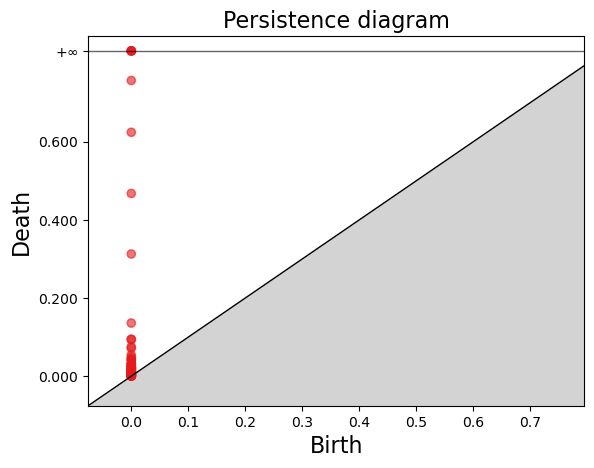

<Figure size 1000x600 with 0 Axes>

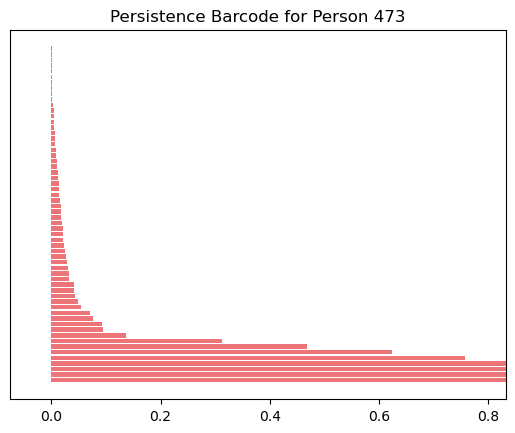

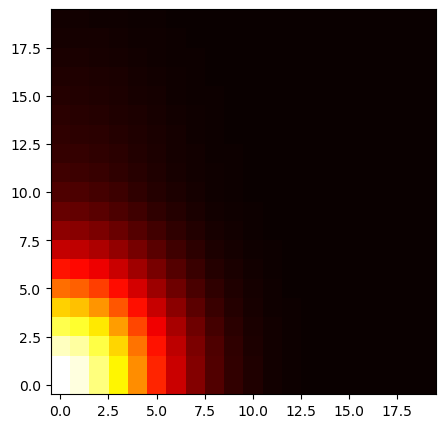

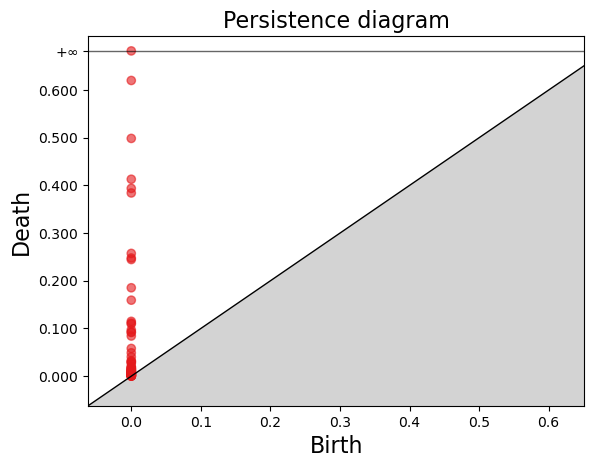

<Figure size 1000x600 with 0 Axes>

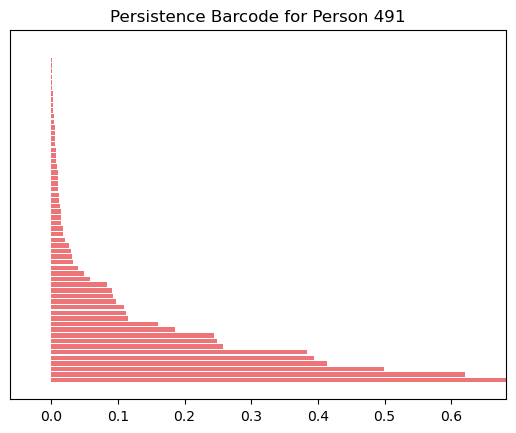

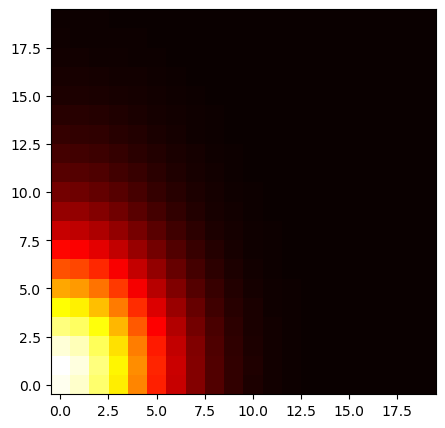

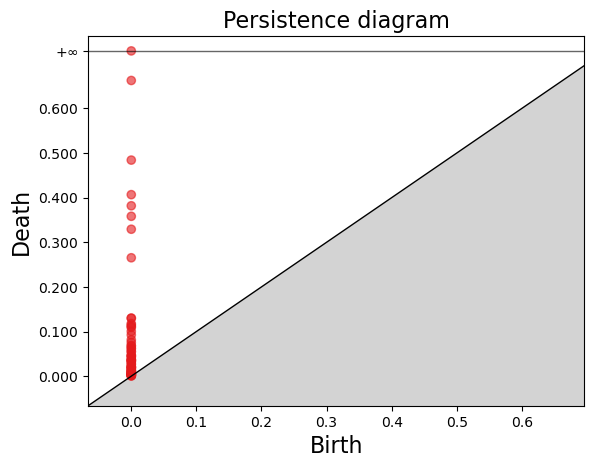

<Figure size 1000x600 with 0 Axes>

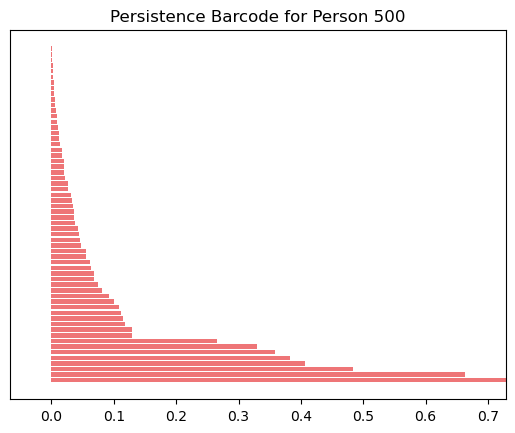

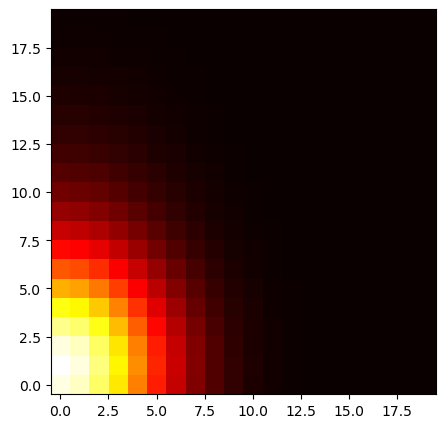

In [7]:
# show plots for randomly selected images from each group 

for index in selected_rows: 
    
    BarCodes_Rips = barcodes_list_mod[index]
    persistence_image_H0 = persistence_img_list_mod[index]
    gd.plot_persistence_diagram(BarCodes_Rips) 
    
    plt.figure(figsize=(10, 6))
    gd.plot_persistence_barcode(BarCodes_Rips)
    plt.title(f'Persistence Barcode for Person {index+1}')
    plt.show()
    
    resolution = [20, 20]
    persistence_image_H0_mat = persistence_image_H0.reshape(resolution)

    plt.figure(figsize=(5, 5))

    plt.imshow(persistence_image_H0_mat, cmap='hot', origin='lower')
    plt.show()

In [8]:
# we are now going to focus on binary classification of group 1: A-fib and group 2: atrial tachycardia because they are the groups with the most variance in shape 

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression

X_main = []


for i in range(0, 291):
    X_main.append(persistence_img_list[i])
for i in range(292,468):
    X_main.append(persistence_img_list[i])
   
y_arr =  np.concatenate([np.zeros(292), np.ones(175)])
X_mat = np.array(X_main)

X_train, X_test, y_train, y_test = train_test_split(
    X_mat, y)



logReg = LogisticRegression(max_iter=1000)
results = logReg.fit(X_train, y_train)
test_result = logReg.predict(X_test)

correct = 0
incorrect = 0
for i in range(len(test_result)):
    if test_result[i] == y_test[i]: 
        correct += 1
    else: 
        incorrect += 1

print(correct/(correct+incorrect))

NameError: name 'y' is not defined

In [ ]:
# now do it with the modified ones and compare the results 

X_main = []


for i in range(0, 291):
    X_main.append(persistence_img_list_mod[i])
for i in range(292,468):
    X_main.append(persistence_img_list_mod[i])
   
y_arr =  np.concatenate([np.zeros(292), np.ones(175)])
X_mat = np.array(X_main)

X_train, X_test, y_train, y_test = train_test_split(
    X_mat, y)


logReg = LogisticRegression(max_iter=1000)
results = logReg.fit(X_train, y_train)
test_result = logReg.predict(X_test)

correct = 0
incorrect = 0
for i in range(len(test_result)):
    if test_result[i] == y_test[i]: 
        correct += 1
    else: 
        incorrect += 1

print(correct/(correct+incorrect))

In [ ]:
# get the data
X = np.array(persistence_img_list[:-2])
print(X.shape)
print(y.shape)
X_train,X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

model = LogisticRegression(max_iter=1000, multi_class='ovr')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(model.score(X_test, y_test))


matrix = confusion_matrix(y_test, y_pred, normalize="pred")
cm = ConfusionMatrixDisplay(matrix, display_labels=[1,2,3,4])

# Plot the confusion matrix
cm.plot(cmap=plt.cm.Blues)  
plt.show()

In [ ]:

# get the data

X = np.array(persistence_img_list_mod[:-2])
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

model = LogisticRegression(max_iter=1000, multi_class='ovr')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(model.score(X_test, y_test))

matrix = confusion_matrix(y_test, y_pred, normalize="pred")
cm = ConfusionMatrixDisplay(matrix, display_labels=[1, 2, 3, 4])

# Plot the confusion matrix
cm.plot(cmap=plt.cm.Blues)
plt.show()